# Introduction to the python control system

This section serves as a guide for a step by step integration of Zahner's external potentiostats (i.e., **PP212, PP222, PP242 or XPOT2**) into Python control system. As other sections do not cover detailed reports on basic connection scheme, this section is a prerequisite for other sections.

Zahner has created customizable building blocks (primitives), consisting of a few commands. Each building block carries out a single measurement, like measuring open circuit voltage, applying a constant current/voltage or a current/voltage ramp etc. These building blocks can be used in any desired sequence one after another and/or in loops. This allow users to design their own measurement methods, suitable to their applications.

**In the following, above-mentioned building blocks will be addressed as "[primitives](https://en.wikipedia.org/wiki/Language_primitive)".**

A complete documentation of the individual primitives can be found on the [API documentation website](http://zahner.de/documentation/zahner_potentiostat/index.html). Below described primitives are linked to their respective API pages.

**The following primitives are currently available and can be used in designing a method.**

* Apply constant voltage/current vs time (potentiostatic or galvanostatic polarization)  
  * [measurePolarization()](http://zahner.de/documentation/zahner_potentiostat/scpi_control/control.html#zahner_potentiostat.scpi_control.control.SCPIDevice.measurePolarization)






* Measure open circuit voltage (single data point; average of 7 measurements) or open circuit voltage scan  
  * [measureOCV()](http://zahner.de/documentation/zahner_potentiostat/scpi_control/control.html#zahner_potentiostat.scpi_control.control.SCPIDevice.measureOCV)  
  * [measureOCVScan()](http://zahner.de/documentation/zahner_potentiostat/scpi_control/control.html#zahner_potentiostat.scpi_control.control.SCPIDevice.measureOCVScan)  


* Apply voltage/current ramps (with minimum possible step size). The slope of the ramp can be defined with measurement time and/or scan rate.
  * [measureRampValueInTime()](http://zahner.de/documentation/zahner_potentiostat/scpi_control/control.html#zahner_potentiostat.scpi_control.control.SCPIDevice.measureRampValueInTime)  
  * [measureRampValueInScanRate()](http://zahner.de/documentation/zahner_potentiostat/scpi_control/control.html#zahner_potentiostat.scpi_control.control.SCPIDevice.measureRampValueInScanRate)  
  * [measureRampScanRateForTime()](http://zahner.de/documentation/zahner_potentiostat/scpi_control/control.html#zahner_potentiostat.scpi_control.control.SCPIDevice.measureRampScanRateForTime)  


* Apply voltage/current ramps (with customizable step size)
  * [measureIEStairs()](http://zahner.de/documentation/zahner_potentiostat/scpi_control/control.html#zahner_potentiostat.scpi_control.control.SCPIDevice.measureIEStairs)  

**As examples, following methods are developed from aforementioned primitives:**  

* Charging or discharging routines  
  * [measureCharge()](http://zahner.de/documentation/zahner_potentiostat/scpi_control/control.html#zahner_potentiostat.scpi_control.control.SCPIDevice.measureCharge)  
  * [measureDischarge()](http://zahner.de/documentation/zahner_potentiostat/scpi_control/control.html#zahner_potentiostat.scpi_control.control.SCPIDevice.measureDischarge)  


* Consecutive polarization measurements or ramps (currently the measurements can be run either in potentiostatic mode or in galvanostatic mode in a single method) 
  * [measureProfile()](http://zahner.de/documentation/zahner_potentiostat/scpi_control/control.html#zahner_potentiostat.scpi_control.control.SCPIDevice.measureProfile)  


* Potentiostatic intermittent titration technique (PITT)  
  * [measurePITT()](http://zahner.de/documentation/zahner_potentiostat/scpi_control/control.html#zahner_potentiostat.scpi_control.control.SCPIDevice.measurePITT)  


* Galvanostatic intermittent titration technique (GITT)
  * [measureGITT()](http://zahner.de/documentation/zahner_potentiostat/scpi_control/control.html#zahner_potentiostat.scpi_control.control.SCPIDevice.measureGITT)  

In [ ]:
from zahner_potentiostat.scpi_control.searcher import SCPIDeviceSearcher
from zahner_potentiostat.scpi_control.serial_interface import SerialCommandInterface, SerialDataInterface
from zahner_potentiostat.scpi_control.control import *
from zahner_potentiostat.scpi_control.datahandler import DataManager
from zahner_potentiostat.scpi_control.datareceiver import TrackTypes
from zahner_potentiostat.display.onlinedisplay import OnlineDisplay

from jupyter_utils import executionInNotebook, notebookCodeToPython

# Search for Zahner potentiostats

Each Zahner external potentiostat provides two serial interfaces upon connection to a computer. These serial interfaces may have different names (whenever the potentiostat is connected to a computer). If more than one potentiostat is connected then the respective serial interfaces must also be assigned to the individual potentiostat.

For an easy integration in python, the following code is available. With the [SCPIDeviceSearcher](http://zahner.de/documentation/zahner_potentiostat/scpi_control/searcher.html), the Zahner potentiostats can be searched. 

The device search only calls serial interfaces to which Zahner potentiostats are connected. These devices (Zahner's external potentiostats) are then identified with the \*IDN? command.  

The function outputs the response (of device) from the serial interfaces in the console window.

The device can be selected via the serial number [selectDevice()](http://zahner.de/documentation/zahner_potentiostat/scpi_control/searcher.html?highlight=select#zahner_potentiostat.scpi_control.searcher.SCPIDeviceSearcher.selectDevice). If no serial number is given, the first device found is used. Upon selecting a device, names of serial interfaces (i.e., COM9, COM10) assigned to the device are returned as strings. If no device is connected, then "interface is not available" is returned.

The serial interfaces communicate with the potentiostat via the [SCPI](https://en.wikipedia.org/wiki/Standard_Commands_for_Programmable_Instruments) protocol. The data comes back with Zahner's own protocol. Documentation on the binary data protocol is available on request.

When a primitive is ran without an error then an output "ok" is returned. This output is not processed by the potentiostat.

In [5]:
if __name__ == '__main__':
    deviceSearcher = SCPIDeviceSearcher()
    deviceSearcher.searchZahnerDevices()
    commandSerial, dataSerial = deviceSearcher.selectDevice("33000")

COM10:
ZAHNER-ELEKTRIK,PP212,33000,1.0.0 binary

COM9:
ZAHNER-ELEKTRIK,PP212,33000,1.0.0



# Establish and initialize connection

After the device has been selected and the serial interfaces are available then the names of serial interfaces are stored in the variables **commandSerial** and **dataSerial** as strings.

If the names of serial interfaces (i.e., COM9, COM10) are known, they can also be passed directly to the [SerialCommandInterface](http://zahner.de/documentation/zahner_potentiostat/scpi_control/serial_interface.html#zahner_potentiostat.scpi_control.serial_interface.SerialCommandInterface) and [SerialDataInterface](http://zahner.de/documentation/zahner_potentiostat/scpi_control/serial_interface.html#zahner_potentiostat.scpi_control.serial_interface.SerialDataInterface) objects.

**commandSerial:**  
The serial interface assigned the name commandSerial is used to control the device. With this serial interface, the commands for abort and reset are executed immediately without waiting for the completion of active measurement.

**dataSerial:**  
The serial interface assigned the name dataSerial receives the data from the device. Data is sent live during a measurement and also at the end of the measurement. 

*Currently, a stand-alone operation is not possible without a computer connected to the device to receive the data.*

With these interfaces, the [potentiostat object](http://zahner.de/documentation/zahner_potentiostat/scpi_control/control.html#zahner_potentiostat.scpi_control.control.SCPIDevice) ZahnerPP2x2 is created, which represents and controls the potentiostat.

In [3]:
    ZahnerPP2x2 = SCPIDevice(SerialCommandInterface(commandSerial), SerialDataInterface(dataSerial))

# Starting the live data display

The following code section shows how the [OnlineDisplay](http://zahner.de/documentation/zahner_potentiostat/display/onlinedisplay.html#zahner_potentiostat.display.onlinedisplay.OnlineDisplay) class can be used to display live voltage and current measurement points.

The function executionInNotebook() is used to check if the execution is taking place in Jupyter notebook or not. As Jupyter cannot display the live measured data so if the execution take place in Jupyter notebook then the online display will not be executed.

In [4]:
    onlineDisplay = None
    if executionInNotebook() == False:
        onlineDisplay = OnlineDisplay(ZahnerPP2x2.getDataReceiver())

# Setting general parameters
First of all, general parameters are set, which will be used in all primitives that will be executed.  

An example of this is given below, where a sampling rate of 25 Hz and potentiostatic operating mode is selected.

In [ ]:
    ZahnerPP2x2.setSamplingFrequency(25)
    ZahnerPP2x2.setCoupling(COUPLING.POTENTIOSTATIC)

# Customize and execute the primitives

In the following example, three polarization measurements are carried out on a capacitor and a resistor, connected in series.

At first, a general parameter, a measurement time of 15 seconds is configured. 

In [ ]:
    ZahnerPP2x2.setMaximumTimeParameter(15)

For the measurement, first a voltage of 0 V is set and the polarization measurement is started.

Afterwards, a voltage of 3 V is set and then second polarization measurement is started.

Finally, the voltage value is set back to 0 V and last polarization measurement is carried out.

In [ ]:
    ZahnerPP2x2.setVoltageParameter(0)
    ZahnerPP2x2.measurePolarization()
    
    ZahnerPP2x2.setVoltageParameter(3)
    ZahnerPP2x2.measurePolarization()
    
    ZahnerPP2x2.setVoltageParameter(0)
    ZahnerPP2x2.measurePolarization()

# Processing of data

The potentiostat contains a [DataReceiver](http://zahner.de/documentation/zahner_potentiostat/scpi_control/datareceiver.html) object, in which the received data is processed and stored.  

This object can be obtained from the potentiostat using the getDataReceiver() method.

In [8]:
    dataReceiver = ZahnerPP2x2.getDataReceiver()

Then, as is shown in the following, individual data tracks from the objects can be obtained for further processing. 

In [9]:
    completeData = dataReceiver.getCompletePoints()

Now complete data can be received as shown in the following example.

The data is stored in a dictionary, for each data track there is a key in the dictionary. The arrays in each key are of the same length.

For example, the content of the variable completeData could look like this:  
completeData = {"[TrackTypes](http://zahner.de/documentation/zahner_potentiostat/scpi_control/datareceiver.html#zahner_potentiostat.scpi_control.datareceiver.TrackTypes).TIME" : [1, 2, 3, 4] , "TrackTypes.VOLTAGE" : [3, 2, 3, 4] , "TrackTypes.CURRENT" : [0, 2, 3, 0]}

In [10]:
    timeData = completeData[TrackTypes.TIME.toString()]
    voltageData = completeData[TrackTypes.VOLTAGE.toString()]
    currentData = completeData[TrackTypes.CURRENT.toString()]
    
    print(currentData[0:10])

[-0.00031085967456119225, -0.0003108896096872264, -0.0003108896096872264, -0.0003108297394351581, -0.0003108297394351581, -0.00031085967456119225, -0.0003108297394351581, -0.0003108896096872264, -0.0003109195448132605, -0.0003109494799392946]


# Plotting and saving the data

To display the measurement results, [DataManager](http://zahner.de/documentation/zahner_potentiostat/scpi_control/datahandler.html) class is implemented.

With this class, current and voltage can be displayed over time. The data can also be saved as a text file.

The following code lines can be used to plot the data.  

If a filename is passed, the plot will be saved under this filename. The two other parameters can be passed if diagram width and height (in inches) are to be corrected.

The file types of the plot are given by [matplotlib](https://matplotlib.org/stable/api/figure_api.html?highlight=savefig#matplotlib.figure.Figure.savefig).

PDF works very well and creates vector graphics which can later be easily integrated into LaTeX.

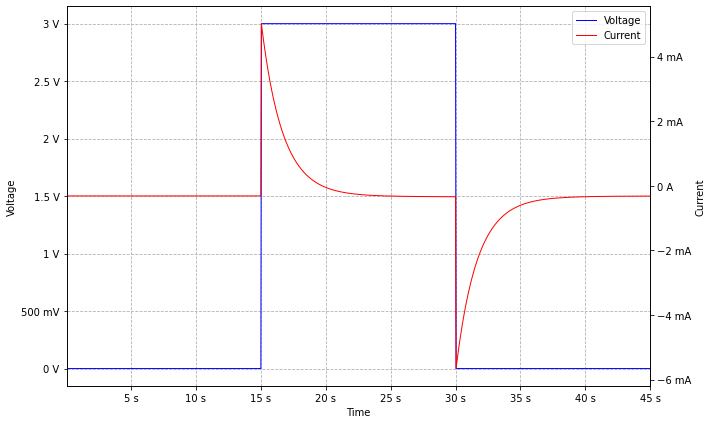

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [11]:
    dataManager = DataManager(dataReceiver)
    dataManager.plotTIUData("polarization.pdf",10,5)

In the polarisation.txt file the stored data is seperated with a **";"**.

In future, exports for new Zahner file formats will be added.
This exported data can then also be opened in [Zahner Analysis](http://zahner.de/products/software/zahner-analysis.html) or Zahner-Lab for evaluation.

In [12]:
    dataManager.saveDataAsText("polarization.txt")

# Close the connection

Close the online display, if it has been opened and close the connection to the device.

In [13]:
    if onlineDisplay != None:
        onlineDisplay.close()
    
    ZahnerPP2x2.close()
    print("finish")

finish


# Deployment of the source code

**The following instruction is not needed by the user.**

It automatically extracts the pure python code from the jupyter notebook to provide it to the user. Thus the user does not need jupyter itself and does not have to copy the code manually.

The source code is saved in a .py file with the same name as the notebook.

In [6]:
    if executionInNotebook() == True:
        notebookCodeToPython("BasicIntroduction.ipynb")